# Third Annual Cavity Meeting
### Examples of profiles for different galaxies

In this tutorial I will show how to use the library for doing the **profiles** with the tools developed. We will:

1. Mask all the sources that are not the galaxy
2. Compute the sky background level and the morphology of the galaxy.
3. Compute three different types of profiles:
4. Use visualization tools to plot the image, mask and profile. 

In [4]:
%matplotlib inline

from AstroPipe.classes import Image, Directories 
from AstroPipe.masking import sexmask
from AstroPipe.profile import Profile, background_estimation
from AstroPipe.plotting import show

from matplotlib import pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")


We will be using three different 

<AxesSubplot:>

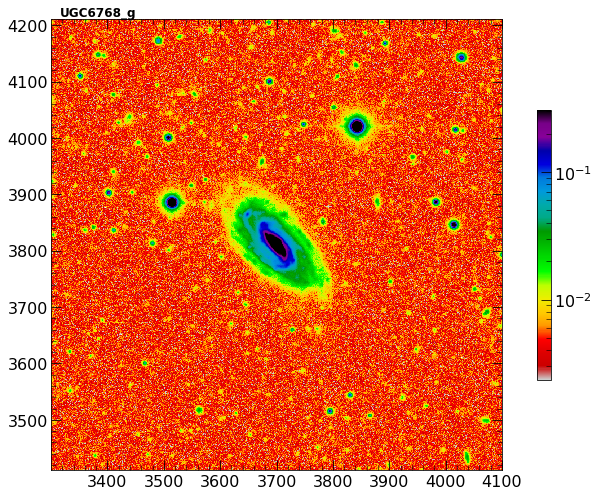

In [6]:

imagefile = '/Users/pmsa/Documents/PhD/Projects/CAVITY/AnualMeeting/Coadds_perfiles/g/32896/Reference_ima.fits'

ra,dec = 176.9551956,43.7482482

image = Image(imagefile, hdu=0, zp=22.5)
image.name = 'UGC6768_g'   # changing Reference_ima to UGC6768_g

image.obj(ra,dec) 

image.show()


Now we use the class *Directories* to stablish the directories where the data is stored. 

FABADA 2-D initialize
Iteration =    24 ; <E> = 126.85 ; Chi^2 = 3.6655e+10/3.850e+07 
Finish at 24 iterations  and with an execute time of 58.02 seconds.


Ouch, SExtractor complains :
b''
Ouch, SExtractor complains :
b''
Ouch, SExtractor complains :
b''


<AxesSubplot:>

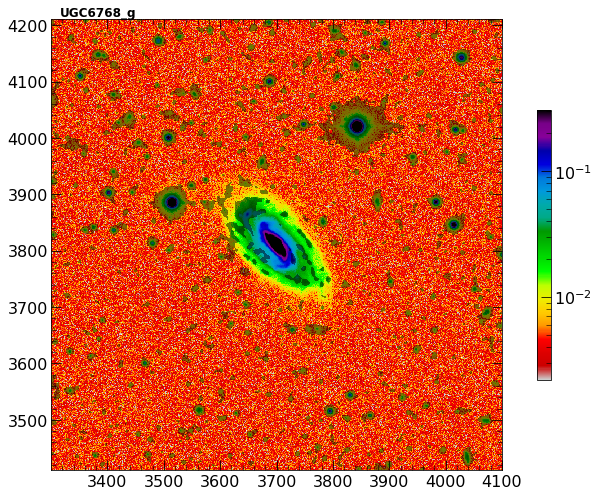

In [11]:
folders = Directories('UGC6768',path=os.path.dirname(imagefile))

sexmask(image, folders) 

image.show()

Image morphology found:
PA = -25.19 deg ;  eps = 0.41
Background estimation:
Background = 1.10e-04 ;  Background std = 3.06e-05 ;  Background radius = 2.64e+02


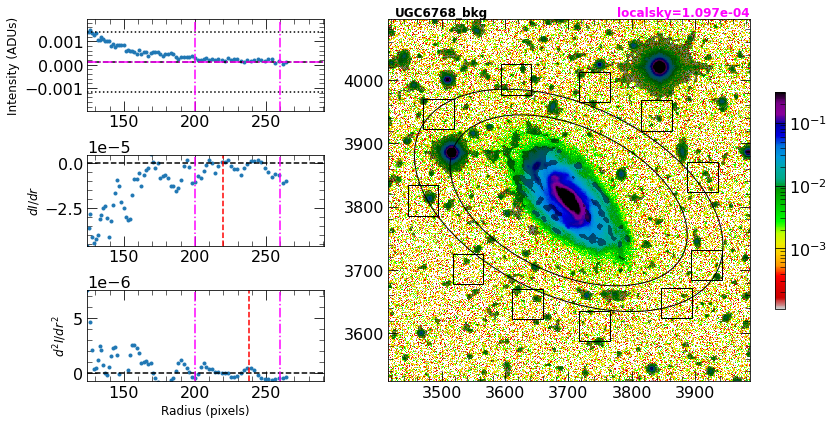

In [12]:
image.get_morphology()

bkg,bkgstd,bkgrad = background_estimation(image.data,image.pix,image.pa,image.eps, growth_rate=1.05,out=folders.out+'/UGC6768_bkg.jpg')

print('Image morphology found:')
print(f'PA = {image.pa:.2f} deg ;  eps = {image.eps:.2f}')
print('Background estimation:')
print(f'Background = {bkg:.2e} ;  Background std = {bkgstd:.2e} ;  Background radius = {bkgrad:.2e}')

IndexError: index 0 is out of bounds for axis 0 with size 0

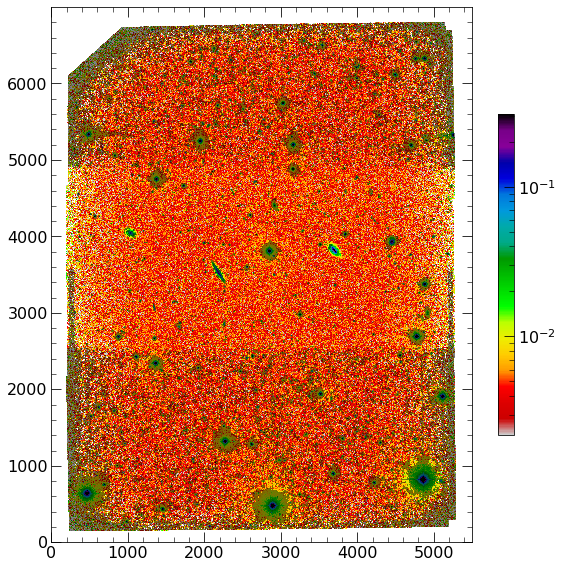

In [14]:
profile = image.isophotal_photometry(max_r=1.8*bkgrad, plot=folders.out+'/UGC6768_isophotal_photometry.jpg')
profile.plot()